---------------------------------------------------------------------------------------------------CNN TRAINING-----------------------------------------------------------------------------------------------------

In [ ]:
import zipfile
import os

zip_path = "/content/RCCB.zip"  # Replace with your actual file path
extract_to = "/content/"  # Change this if needed

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Unzipping complete!")


Unzipping complete!


In [ ]:

import zipfile
import os

zip_path = "/content/RGB.zip"  # Replace with your actual file path
extract_to = "/content/"  # Change this if needed

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Unzipping complete!")


Unzipping complete!


In [ ]:
!pip install pytorch-msssim


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

CODE 1

Epoch 1/20, Loss: 0.1763
Epoch 2/20, Loss: 0.0815
Epoch 3/20, Loss: 0.0724
Epoch 4/20, Loss: 0.0689
Epoch 5/20, Loss: 0.0677
Epoch 6/20, Loss: 0.0660
Epoch 7/20, Loss: 0.0631
Epoch 8/20, Loss: 0.0624
Epoch 9/20, Loss: 0.0590
Epoch 10/20, Loss: 0.0553
Epoch 11/20, Loss: 0.0548
Epoch 12/20, Loss: 0.0537
Epoch 13/20, Loss: 0.0523
Epoch 14/20, Loss: 0.0499
Epoch 15/20, Loss: 0.0515
Epoch 16/20, Loss: 0.0472
Epoch 17/20, Loss: 0.0515
Epoch 18/20, Loss: 0.0494
Epoch 19/20, Loss: 0.0464
Epoch 20/20, Loss: 0.0480


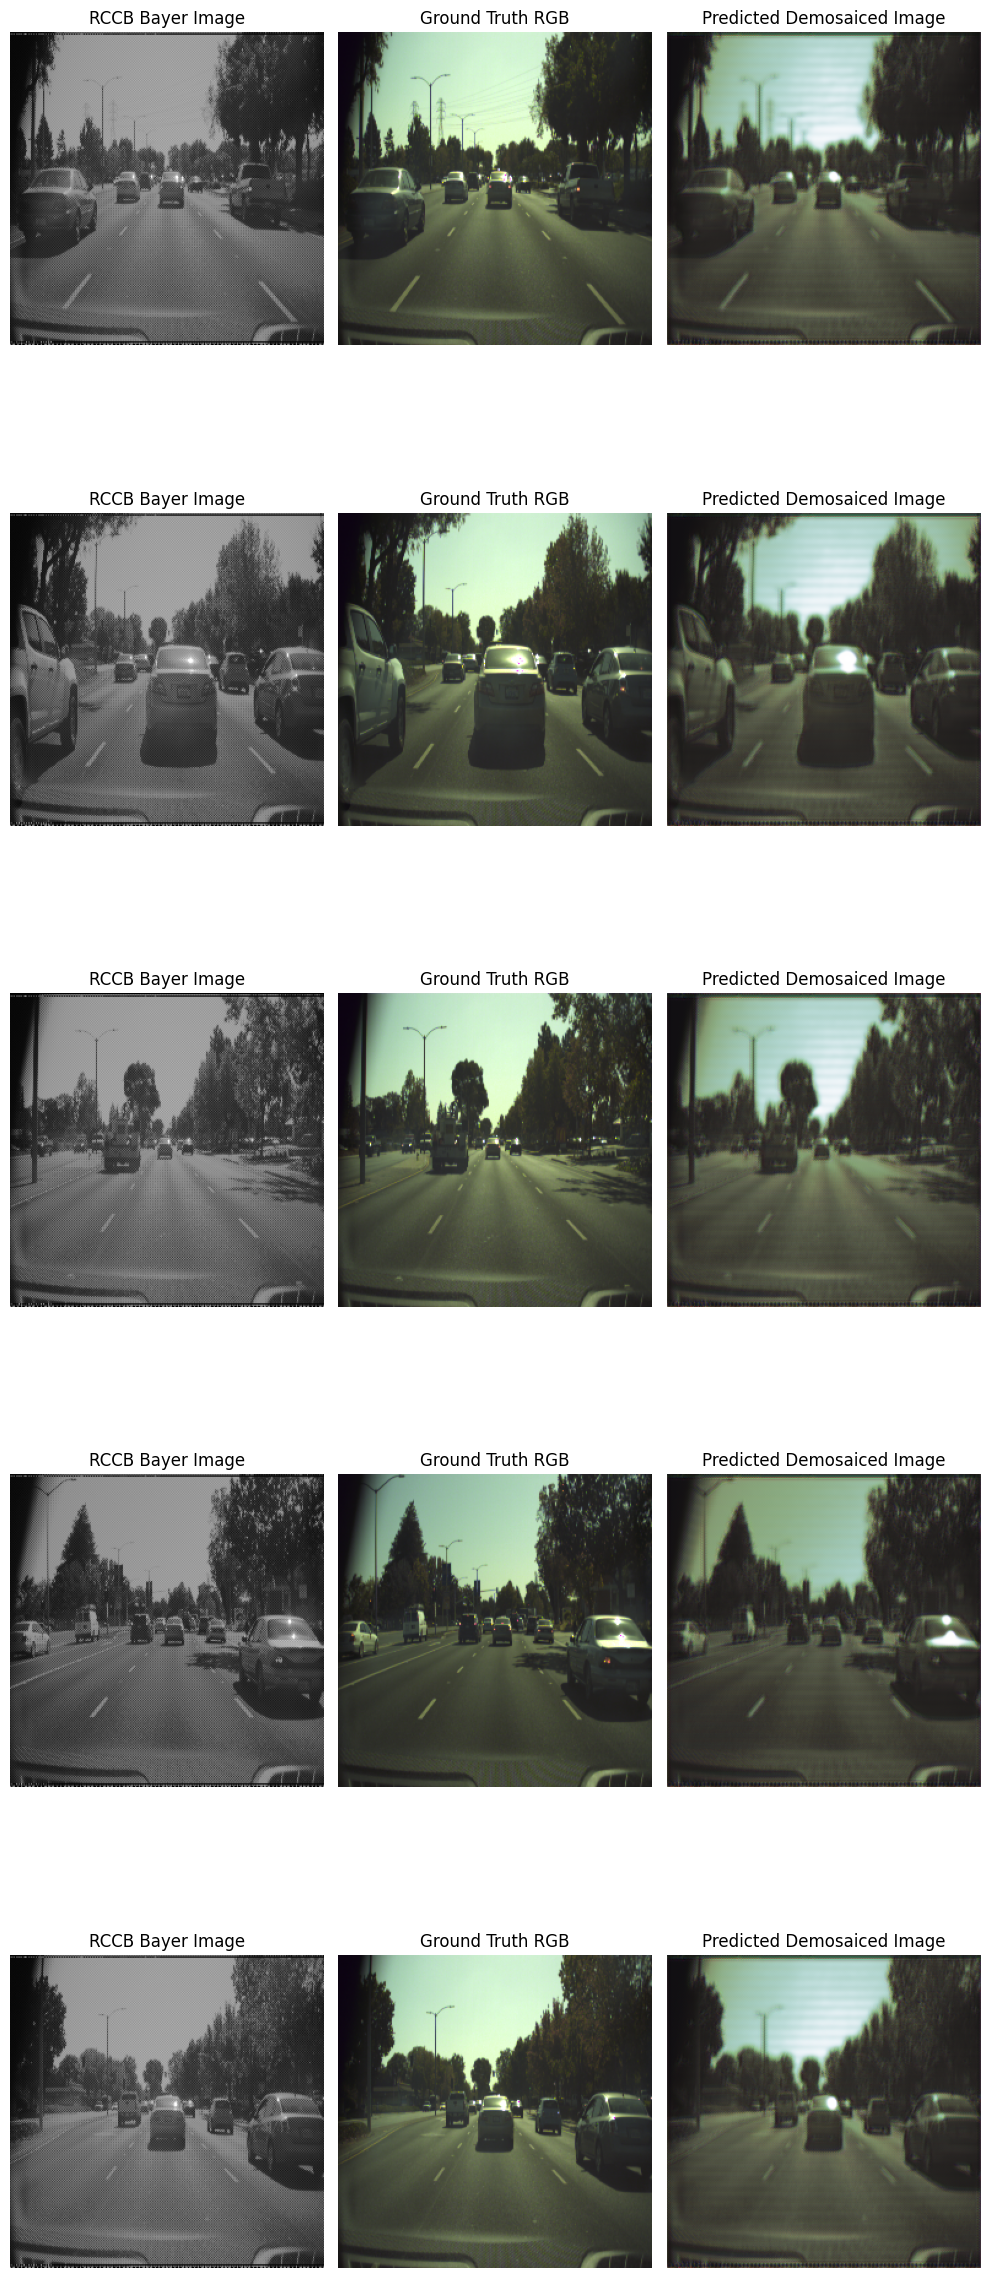

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

# Apply RCCB Bayer filter
def apply_RCCB_filter(image):
    h, w = image.shape
    bayer_image = np.zeros((h, w),dtype=np.uint8)

    # RCCB Pattern
    bayer_image[0::2, 0::2] = image[0::2, 0::2]  # Red
    bayer_image[0::2, 1::2] = image[0::2, 1::2]  # Clear
    bayer_image[1::2, 0::2] = image[1::2, 0::2]  # Clear
    bayer_image[1::2, 1::2] = image[1::2, 1::2]  # Blue

    return bayer_image

# Custom Dataset Class
class RCCBDataset(Dataset):
    def __init__(self, pgm_folder, rgb_folder, img_size=(256, 256)):
        self.pgm_files = sorted(glob.glob(pgm_folder + "/*.pgm"))
        self.rgb_files = sorted(glob.glob(rgb_folder + "/*.png"))  # Change extension if needed
        self.img_size = img_size

    def __len__(self):
        return len(self.pgm_files)

    def __getitem__(self, idx):
        pgm_path = self.pgm_files[idx]
        rgb_path = self.rgb_files[idx]

        # Load and resize PGM image
        pgm = cv2.imread(pgm_path, cv2.IMREAD_UNCHANGED)
        pgm = cv2.resize(pgm, self.img_size)
        pgm = np.array(pgm, dtype=np.float32)

        # Normalize and apply RCCB filter
        pgm = (pgm / np.max(pgm)) * 255.0  # Normalize to 0-255
        bayer_img = apply_RCCB_filter(pgm) / 255.0  # Normalize again

        # Load and resize RGB image
        rgb = cv2.imread(rgb_path)
        rgb = cv2.resize(rgb, self.img_size)
        rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)  # Convert to RGB
        rgb = rgb / 255.0  # Normalize

        # Convert to PyTorch tensors
        bayer_img = torch.tensor(bayer_img, dtype=torch.float32).unsqueeze(0)  # Add channel dim
        rgb = torch.tensor(rgb, dtype=torch.float32).permute(2, 0, 1)  # Convert to CxHxW

        return bayer_img, rgb

# Improved CNN Modelx
class DemosaicCNN(nn.Module):
    def __init__(self):
        super(DemosaicCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )

        self.conv6 = nn.Conv2d(64, 3, kernel_size=3, padding=1)  # Output 3 channels (RGB)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x4 = self.conv4(x3) + x2  # Skip Connection
        x5 = self.conv5(x4) + x1  # Skip Connection
        x6 = self.conv6(x5)
        return torch.sigmoid(x6)  # Normalize output

# Load Dataset
dataset = RCCBDataset("/content/RCCB", "/content/RGB")
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DemosaicCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.L1Loss()  # L1 Loss reduces blurring

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training Loop
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for bayer_imgs, rgb_imgs in train_loader:
        bayer_imgs, rgb_imgs = bayer_imgs.to(device), rgb_imgs.to(device)

        optimizer.zero_grad()
        output = model(bayer_imgs)
        loss = criterion(output, rgb_imgs)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    scheduler.step()  # Update learning rate
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

# Test and Visualize Results
model.eval()
num_images = 5  # Number of images to display

with torch.no_grad():
    bayer_batch, rgb_batch = next(iter(test_loader))
    bayer_batch, rgb_batch = bayer_batch.to(device), rgb_batch.to(device)

    predicted_batch = model(bayer_batch).cpu().numpy()
    bayer_batch = bayer_batch.cpu().numpy()
    rgb_batch = rgb_batch.cpu().numpy()

    fig, axes = plt.subplots(num_images, 3, figsize=(10, 5 * num_images))

    for i in range(num_images):
        bayer_img = bayer_batch[i, 0, :, :]
        rgb_gt = rgb_batch[i].transpose(1, 2, 0)
        predicted_rgb = np.clip(predicted_batch[i].transpose(1, 2, 0), 0, 1)

        axes[i, 0].imshow(bayer_img, cmap="gray")
        axes[i, 0].set_title("RCCB Bayer Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(rgb_gt)
        axes[i, 1].set_title("Ground Truth RGB")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(predicted_rgb)
        axes[i, 2].set_title("Predicted Demosaiced Image")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()



CODE 2

Epoch 1/20, Loss: 0.2219
Epoch 2/20, Loss: 0.1705
Epoch 3/20, Loss: 0.1613
Epoch 4/20, Loss: 0.1545
Epoch 5/20, Loss: 0.1457
Epoch 6/20, Loss: 0.1320
Epoch 7/20, Loss: 0.1217
Epoch 8/20, Loss: 0.1153
Epoch 9/20, Loss: 0.1034
Epoch 10/20, Loss: 0.0858
Epoch 11/20, Loss: 0.0765
Epoch 12/20, Loss: 0.0753
Epoch 13/20, Loss: 0.0764
Epoch 14/20, Loss: 0.0695
Epoch 15/20, Loss: 0.0638
Epoch 16/20, Loss: 0.0648
Epoch 17/20, Loss: 0.0648
Epoch 18/20, Loss: 0.0559
Epoch 19/20, Loss: 0.0569
Epoch 20/20, Loss: 0.0533


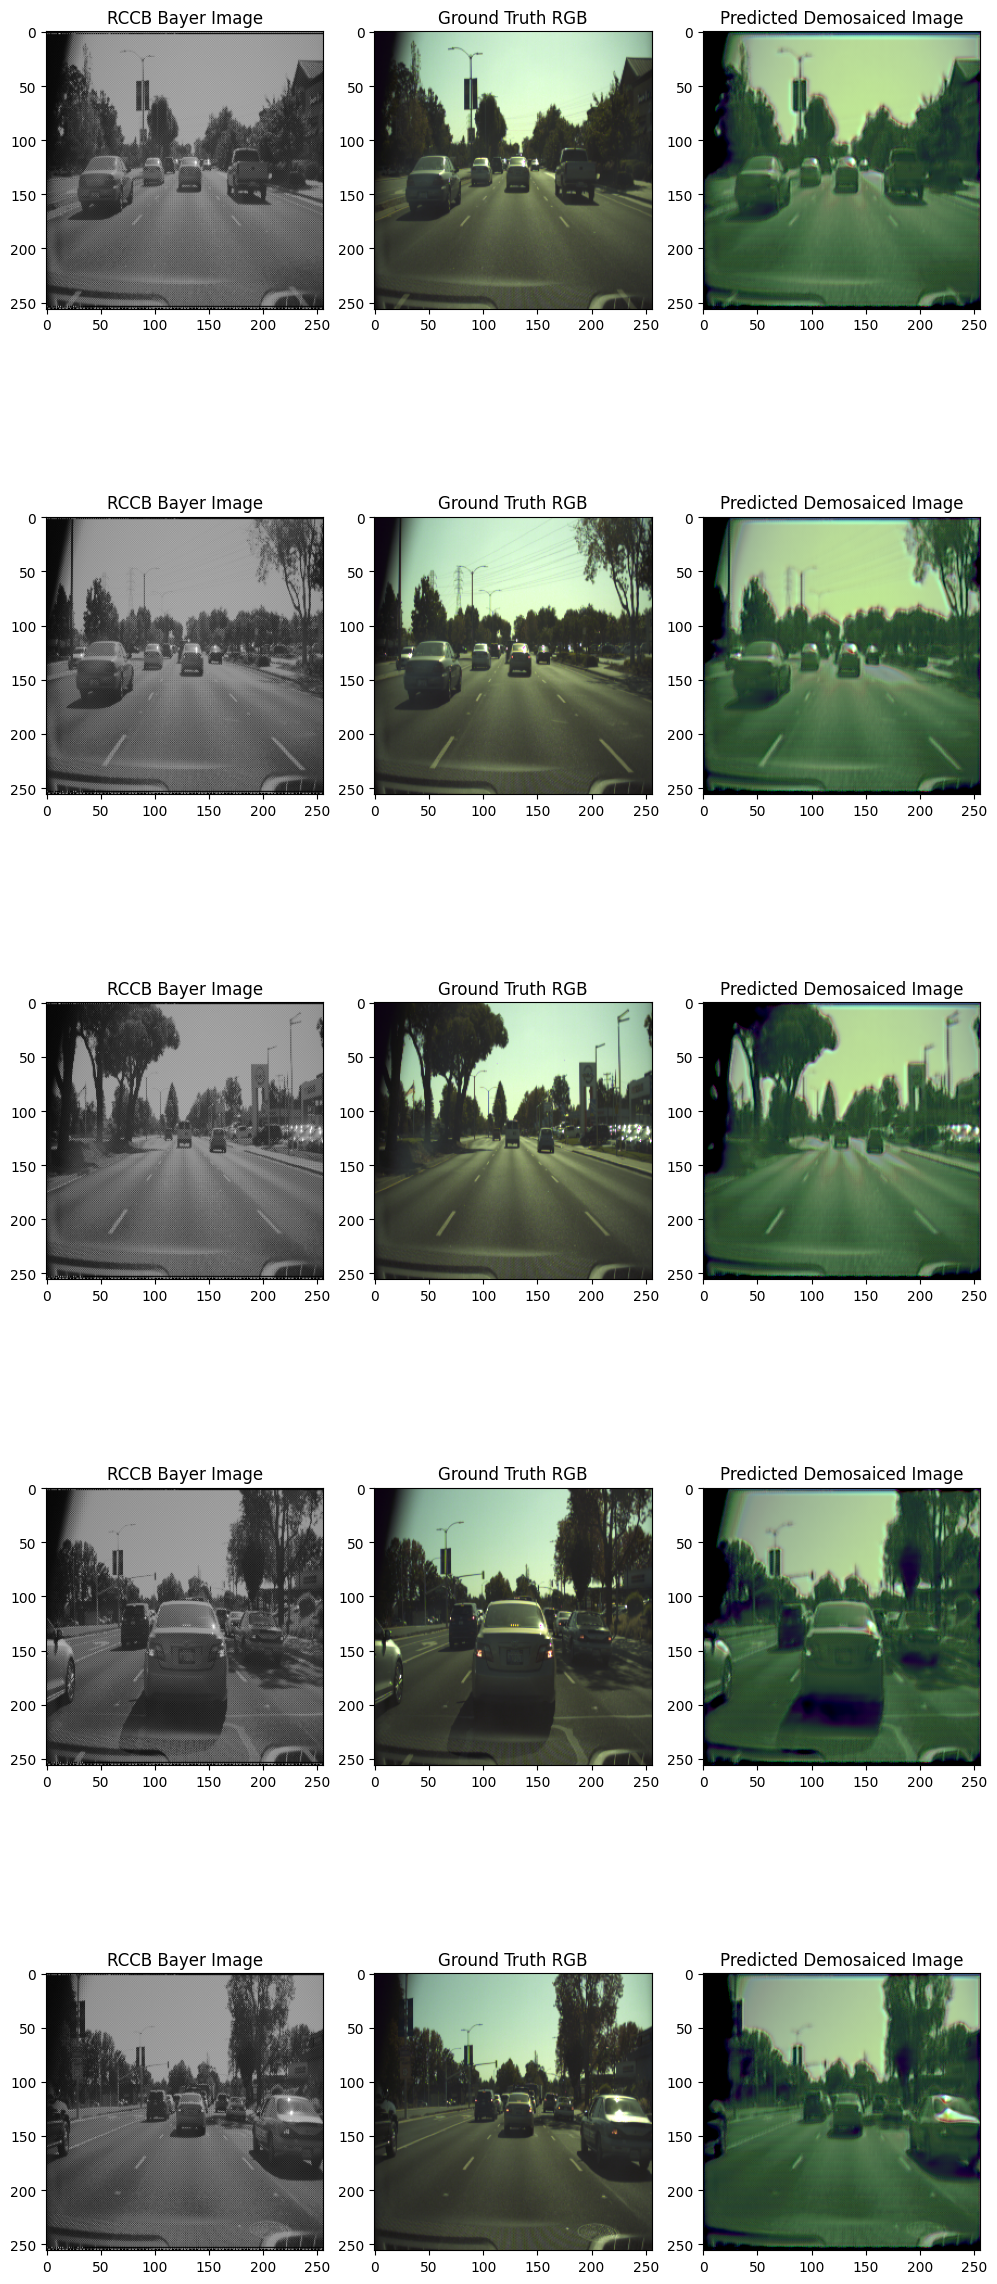

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pytorch_msssim

# Apply RCCB Bayer filter
def apply_RCCB_filter(image):
    h, w = image.shape
    bayer_image = np.zeros((h, w), dtype=np.float32)

    # RCCB Pattern
    bayer_image[0::2, 0::2] = image[0::2, 0::2]  # Red
    bayer_image[0::2, 1::2] = image[0::2, 1::2]  # Clear
    bayer_image[1::2, 0::2] = image[1::2, 0::2]  # Clear
    bayer_image[1::2, 1::2] = image[1::2, 1::2]  # Blue

    return bayer_image / 15.0  # Normalize properly

# Custom Dataset Class
class RCCBDataset(Dataset):
    def __init__(self, pgm_folder, rgb_folder, img_size=(256, 256)):
        self.pgm_files = sorted(glob.glob(pgm_folder + "/*.pgm"))
        self.rgb_files = sorted(glob.glob(rgb_folder + "/*.png"))
        self.img_size = img_size

    def __len__(self):
        return len(self.pgm_files)

    def __getitem__(self, idx):
        pgm = cv2.imread(self.pgm_files[idx], cv2.IMREAD_UNCHANGED)
        pgm = cv2.resize(pgm, self.img_size).astype(np.float32)
        pgm = (pgm / np.max(pgm)) * 15.0  # Normalize within 0-15
        bayer_img = apply_RCCB_filter(pgm)

        rgb = cv2.imread(self.rgb_files[idx])
        rgb = cv2.resize(rgb, self.img_size)
        rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB) / 255.0

        return torch.tensor(bayer_img, dtype=torch.float32).unsqueeze(0), torch.tensor(rgb, dtype=torch.float32).permute(2, 0, 1)

# Improved CNN Model
class DemosaicCNN(nn.Module):
    def __init__(self):
        super(DemosaicCNN, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1, 64, 5, padding=2), nn.ReLU(), nn.BatchNorm2d(64))
        self.conv2 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(128))
        self.conv3 = nn.Sequential(nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(128))
        self.conv4 = nn.Sequential(nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(128))
        self.conv5 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64))
        self.match_x2 = nn.Conv2d(128, 64, kernel_size=1)  # Added to match dimensions
        self.conv6 = nn.Conv2d(64, 3, 3, padding=1)

    def forward(self, x):
        x1 = self.conv1(x)  # (1 → 64)
        x2 = self.conv2(x1)  # (64 → 128)
        x3 = self.conv3(x2)  # (128 → 128)
        x4 = self.conv4(x3) + x3  # (128 → 128) Skip connection
        x5 = self.conv5(x4) + self.match_x2(x2)  # Ensure channel match (128 → 64)
        x6 = self.conv6(x5)  # (64 → 3)
        return x6.clamp(0, 1)

# Load Dataset
dataset = RCCBDataset("/content/RCCB", "/content/RGB")
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DemosaicCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)
criterion = lambda output, target: 0.8 * nn.L1Loss()(output, target) + 0.2 * (1 - pytorch_msssim.ssim(output, target))

# Training Loop
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for bayer_imgs, rgb_imgs in train_loader:
        bayer_imgs, rgb_imgs = bayer_imgs.to(device), rgb_imgs.to(device)
        optimizer.zero_grad()
        output = model(bayer_imgs)
        loss = criterion(output, rgb_imgs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    scheduler.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

# Test and Visualize Results
model.eval()
num_images = 5
with torch.no_grad():
    bayer_batch, rgb_batch = next(iter(test_loader))
    bayer_batch, rgb_batch = bayer_batch.to(device), rgb_batch.to(device)
    predicted_batch = model(bayer_batch).cpu().numpy()
    bayer_batch, rgb_batch = bayer_batch.cpu().numpy(), rgb_batch.cpu().numpy()

    fig, axes = plt.subplots(num_images, 3, figsize=(10, 5 * num_images))
    for i in range(num_images):
        axes[i, 0].imshow(bayer_batch[i, 0, :, :], cmap="gray")
        axes[i, 0].set_title("RCCB Bayer Image")
        axes[i, 1].imshow(rgb_batch[i].transpose(1, 2, 0))
        axes[i, 1].set_title("Ground Truth RGB")
        axes[i, 2].imshow(np.clip(predicted_batch[i].transpose(1, 2, 0), 0, 1))
        axes[i, 2].set_title("Predicted Demosaiced Image")
    plt.tight_layout()
    plt.show()
